# Lead Value Prediction Models

In [2]:
import numpy as np
import pandas as pd

## Import Raw Data

In [3]:
# report contains all quotes and orders data in 2017
report = pd.read_csv('../report1701-1708.csv', na_values=['','null','Not quoted yet','NA','<NA>','No'], encoding='latin-1')
# enrich contains all correctly enriched customer information from Clearbit and Orb
enrich = pd.read_csv('full_enriched_customer.csv', na_values=['','NA'], encoding='latin-1')

/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (38,40,41,54,55,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [4]:
full = pd.merge(report, enrich, on='Customer.No', how='left')
full['Request.Date'] = pd.to_datetime(full['Request.Date'],format='%Y-%m-%d %H:%M:%S')
full['Invoice.Accept.Date'] = full['Invoice.Accept.Date'].fillna('2100-01-01 00:00:00')
full['Invoice.Accept.Date'] = pd.to_datetime(full['Invoice.Accept.Date'],format='%Y-%m-%d %H:%M:%S')
full['Order.Number'].replace("[^0-9]+$","",inplace=True,regex=True)
full['Order.Number'] = full['Order.Number'].fillna('no_order')
full['Product'].replace("^Custom ","",inplace=True,regex=True)
full['Paid.Amount'] = full['Paid.Amount'].fillna(0)
full[['industry_category','industry_sub_category','range_employees','range_revenue']] = full[['industry_category','industry_sub_category','range_employees','range_revenue']].fillna('personal')
# add flags whether first quote
full = full[full['Quote.No'].notnull()]
full = full.sort_values(['Request.Date','Invoice.Accept.Date'])
# change definition of new quote to quotes before first order
full['paid_amt_lag'] = full.groupby('Customer.No')['Paid.Amount'].shift(1).fillna(0)
full['whether_new'] = np.where((full['Customer.No'].duplicated())&(~(full['paid_amt_lag']==0)),0,1)
full = full[['Quote.No','Request.Date','Invoice.Accept.Date','Product','Order.Number','Customer.No','Paid.Amount','industry_category','industry_sub_category','range_employees','range_revenue','whether_new','Sales.Rep']]
grouped_amt = full[['Quote.No','Order.Number','Paid.Amount']].copy()
grouped_amt = grouped_amt.groupby(['Quote.No','Order.Number']).sum().reset_index()
full = full[(~full[['Order.Number']].duplicated())|(full['Order.Number']=='no_order')]
full = pd.merge(full[full.columns.difference(['Paid.Amount'])], grouped_amt, on=['Quote.No','Order.Number'], how='left')

## Building Expert Variables

In [5]:
full['whether_order'] = np.where(full['Paid.Amount']==0,0,1)

# calculate the historical aov, average close rate, average sales cycle
full['ones'] = 1
full.ix[0, 'ones'] = 0
full['amt_lag'] = full['Paid.Amount'].shift(1).fillna(0)
full['whether_order_lag'] = full['whether_order'].shift(1).fillna(0)

full['aov'] = (full['amt_lag'].cumsum()/full['whether_order_lag'].cumsum()).fillna(0)
full['avg_close_rate'] = (full['whether_order_lag'].cumsum()/full['ones'].cumsum()).fillna(0)

# calculate the number of quotes since last order
full['order_grp'] = full.groupby('Customer.No')['whether_order'].cumsum()
full['quotes_since'] = full.groupby(['Customer.No','order_grp']).cumcount()
full['quotes_since_last_order'] = np.where(full['order_grp']==0,full['quotes_since']+1,full['quotes_since'])
full['quotes_since_last_order'] = np.where(full['whether_order']==1,full.groupby('Customer.No')['quotes_since_last_order'].shift(1).fillna(0)+1,full['quotes_since_last_order'])

# add the lag1 columns for paid.amount, whether_order, sales_cycle for each category
full['product_amt_lag'] = full.groupby('Product')['Paid.Amount'].shift(1).fillna(0)
full['industry_category_amt_lag'] = full.groupby('industry_category')['Paid.Amount'].shift(1).fillna(0)
full['industry_sub_category_amt_lag'] = full.groupby('industry_sub_category')['Paid.Amount'].shift(1).fillna(0)
full['range_employees_amt_lag'] = full.groupby('range_employees')['Paid.Amount'].shift(1).fillna(0)
full['range_revenue_amt_lag'] = full.groupby('range_revenue')['Paid.Amount'].shift(1).fillna(0)

full['product_order_lag'] = full.groupby('Product')['whether_order'].shift(1).fillna(0)
full['industry_category_order_lag'] = full.groupby('industry_category')['whether_order'].shift(1).fillna(0)
full['industry_sub_category_order_lag'] = full.groupby('industry_sub_category')['whether_order'].shift(1).fillna(0)
full['range_employees_order_lag'] = full.groupby('range_employees')['whether_order'].shift(1).fillna(0)
full['range_revenue_order_lag'] = full.groupby('range_revenue')['whether_order'].shift(1).fillna(0)


# calculate AOV by product, industry_category, industry_sub_category, range_employee, range_revenue based on lag1 values
full['product_aov'] = (full.groupby('Product')['product_amt_lag'].cumsum()/full.groupby('Product')['product_order_lag'].cumsum()).fillna(0)
full['industry_category_aov'] = (full.groupby('industry_category')['industry_category_amt_lag'].cumsum()/full.groupby('industry_category')['industry_category_order_lag'].cumsum()).fillna(0)
full['industry_sub_category_aov'] = (full.groupby('industry_sub_category')['industry_sub_category_amt_lag'].cumsum()/full.groupby('industry_sub_category')['industry_sub_category_order_lag'].cumsum()).fillna(0)
full['range_employees_aov'] = (full.groupby('range_employees')['range_employees_amt_lag'].cumsum()/full.groupby('range_employees')['range_employees_order_lag'].cumsum()).fillna(0)
full['range_revenue_aov'] = (full.groupby('range_revenue')['range_revenue_amt_lag'].cumsum()/full.groupby('range_revenue')['range_revenue_order_lag'].cumsum()).fillna(0)

# calculate historical close rate and average sales cycle 
# by product, industry_category, industry_sub_category, range_employee, range_revenue based on lag1 values
full['product_close_rate'] = (full.groupby('Product')['product_order_lag'].cumsum()/full.groupby('Product').cumcount()).fillna(0)
full['industry_category_close_rate'] = (full.groupby('industry_category')['industry_category_order_lag'].cumsum()/full.groupby('industry_category').cumcount()).fillna(0)
full['industry_sub_category_close_rate'] = (full.groupby('industry_sub_category')['industry_sub_category_order_lag'].cumsum()/full.groupby('industry_sub_category').cumcount()).fillna(0)
full['range_employees_close_rate'] = (full.groupby('range_employees')['range_employees_order_lag'].cumsum()/full.groupby('range_employees').cumcount()).fillna(0)
full['range_revenue_close_rate'] = (full.groupby('range_revenue')['range_revenue_order_lag'].cumsum()/full.groupby('range_revenue').cumcount()).fillna(0)

# calculate customer total spend, total orders, AOV, average close rate, average sales cycle
full['cust_amt_lag'] = full.groupby('Customer.No')['Paid.Amount'].shift(1).fillna(0)
full['cust_order_lag'] = full.groupby('Customer.No')['whether_order'].shift(1).fillna(0)

full['cust_tot_spend'] = full.groupby('Customer.No')['cust_amt_lag'].cumsum()
full['cust_tot_orders'] = full.groupby('Customer.No')['cust_order_lag'].cumsum()
full['cust_aov'] = (full['cust_tot_spend']/full['cust_tot_orders']).fillna(0)
full['cust_close_rate'] = (full['cust_tot_orders']/full.groupby('Customer.No').cumcount()).fillna(0)

# caculate AOV, average close rate, average sales cycle for new/old customer
full['whether_new_amt_lag'] = full.groupby('whether_new')['Paid.Amount'].shift(1).fillna(0)
full['whether_new_order_lag'] = full.groupby('whether_new')['whether_order'].shift(1).fillna(0)

full['whether_new_aov'] = (full.groupby('whether_new')['whether_new_amt_lag'].cumsum()/full.groupby('whether_new')['whether_new_order_lag'].cumsum()).fillna(0)
full['whether_new_close_rate'] = (full.groupby('whether_new')['whether_new_order_lag'].cumsum()/full.groupby('whether_new').cumcount()).fillna(0)

# caculate AOV, average close rate, average sales cycle by sales rep
full['sales_rep_amt_lag'] = full.groupby('Sales.Rep')['Paid.Amount'].shift(1).fillna(0)
full['sales_rep_order_lag'] = full.groupby('Sales.Rep')['whether_order'].shift(1).fillna(0)

full['sales_rep_aov'] = (full.groupby('Sales.Rep')['sales_rep_amt_lag'].cumsum()/full.groupby('Sales.Rep')['sales_rep_order_lag'].cumsum()).fillna(0)
full['sales_rep_close_rate'] = (full.groupby('Sales.Rep')['sales_rep_order_lag'].cumsum()/full.groupby('Sales.Rep').cumcount()).fillna(0)


In [6]:
# assign the previous historical value for the missing aov, acr, asc
col_types = ['product', 'industry_category', 'industry_sub_category', 'range_employees',
             'range_revenue', 'cust', 'whether_new', 'sales_rep']
for col in col_types:
    full[col+'_aov'] = np.where(full[col+'_aov']==0, full['aov'], full[col+'_aov'])
    full[col+'_close_rate'] = np.where(full[col+'_close_rate']==0, full['avg_close_rate'], full[col+'_close_rate'])

## Load Machine Learning Packages

In [7]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
# remove auxiliary variables
df = full[full.columns.difference(['whether_order','order_grp','quotes_since','ones'])].copy().fillna(0)
# take a look to all the fields
df.columns

Index([                     u'Customer.No',
                    u'Invoice.Accept.Date',
                           u'Order.Number',
                            u'Paid.Amount',
                                u'Product',
                               u'Quote.No',
                           u'Request.Date',
                              u'Sales.Rep',
                                u'amt_lag',
                                    u'aov',
                         u'avg_close_rate',
                           u'cust_amt_lag',
                               u'cust_aov',
                        u'cust_close_rate',
                         u'cust_order_lag',
                        u'cust_tot_orders',
                         u'cust_tot_spend',
                      u'industry_category',
              u'industry_category_amt_lag',
                  u'industry_category_aov',
           u'industry_category_close_rate',
            u'industry_category_order_lag',
                  u'industry_sub

## Preprocessing

In [9]:
# z-zcaling all features, note that we only use numeric variables as features 
# z-zcaling all features, note that we only use numeric variables as features 
df1 = df.copy()
cols = ['aov', 'avg_close_rate',
        'whether_new_aov', 'whether_new_close_rate',
        'cust_tot_spend','cust_tot_orders','cust_aov','cust_close_rate','quotes_since_last_order',
        'product_aov','product_close_rate',
        'industry_category_aov','industry_category_close_rate',
        'industry_sub_category_aov','industry_sub_category_close_rate',
        'range_employees_aov','range_employees_close_rate',
        'range_revenue_aov','range_revenue_close_rate',
        'sales_rep_aov','sales_rep_close_rate']

df1[cols] = scale(df1[cols])
features = df1[cols]

# here y is the actual order value (Paid.Amount)
order_value = df1['Paid.Amount']

In [10]:
# train-test split. 75% as training and 25% as testing
x_train, x_test, y_train, y_test = train_test_split(features, order_value, test_size=0.25, random_state=31)

In [11]:
# neutralize the sales rep variables
x_test.loc[:,'sales_rep_aov'] = x_test['aov']
x_test.loc[:,'sales_rep_close_rate'] = x_test['avg_close_rate']

/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Modeling

#### XGBoost Regression

In [12]:
# XGBoost is the state-of-art ensemble boosted tree framework which usually performs well but trained slowly
# Fit XGBoost model and tune parameters manually (expensive to apply cross-validation if data is large)
xgb_reg = XGBRegressor(max_depth=5, n_estimators=200, learning_rate=0.1, reg_alpha=1, reg_lambda=3, random_state=31)
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=31,
       reg_alpha=1, reg_lambda=3, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [13]:
# Evaluate the XGboost regression model by test MSE
xgb_pred = xgb_reg.predict(x_test)
xgb_mse = mean_squared_error(y_test,xgb_pred)
print("XGBoost regression test mean square error: %0.2f") % xgb_mse

XGBoost regression test mean square error: 43453.05


#### Re-train XGB on Entire Data

In [14]:
# Since XGB model has the best test result among all four models, it should be applied and retrained on all data
xgb_x = df1[cols]
xgb_y = df1['Paid.Amount']
xgb_full_reg = XGBRegressor(max_depth=4, n_estimators=400, learning_rate=0.04, reg_alpha=6, reg_lambda=11, random_state=31)
xgb_full_reg.fit(xgb_x, xgb_y)
xgb_full_pred = xgb_full_reg.predict(xgb_x)

#### Add Prediction Result to Original Data

In [15]:
df1['xgb_full_pred_amt'] = xgb_full_pred
df1.ix[df1['xgb_full_pred_amt']<20,'xgb_full_pred_amt'] = 0
# mean_squared_error(df1['Paid.Amount'],df1['xgb_full_pred_amt'])
# training MSE is about 6629
df2 = pd.merge(df, df1, on=['Product','industry_category','industry_sub_category','range_employees','range_revenue','Customer.No','Quote.No','Request.Date','Invoice.Accept.Date','Order.Number','Sales.Rep','whether_new','Paid.Amount'], how='left')
#df2.to_csv('lead_value_prediction.csv',encoding='utf-8')

## Visualization

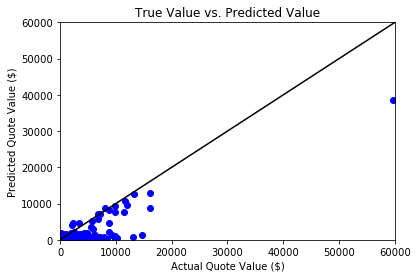

In [16]:
# compare true values and predicted values
plt.figure()

plt.plot(df2['Paid.Amount'], df2['xgb_full_pred_amt'], 'bo', ms=2)
plt.plot(df2['Paid.Amount'], df2['xgb_full_pred_amt'], 'bo', [0,60000], [0,60000], 'k')
plt.axis([0, 60000, 0, 60000])
plt.xlabel('Actual Quote Value ($)')
plt.ylabel('Predicted Quote Value ($)')
plt.title('True Value vs. Predicted Value')

plt.show()

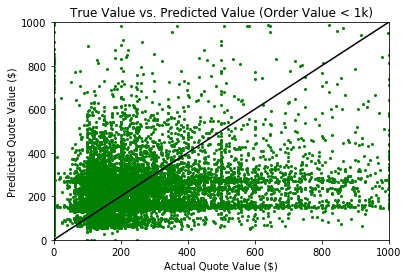

In [17]:
# compare true values and predicted values for true values < $1,000
plt.figure()

plt.plot(df2['Paid.Amount'], df2['xgb_full_pred_amt'], 'go', ms=2)
plt.plot([0,1000], [0,1000], 'k')
plt.axis([0, 1000, 0, 1000])
plt.xlabel('Actual Quote Value ($)')
plt.ylabel('Predicted Quote Value ($)')
plt.title('True Value vs. Predicted Value (Order Value < 1k)')

plt.show()

In [23]:
#a = pd.DataFrame({'id':['x','x','x','y','y','y'],
#                 'date':['2010-05-01','2010-05-01','2010-01-02','2010-02-04','2010-04-05','2010-04-05'],
#                 'order':['x1','x1','x2','y1','y2','y2'],
#                 'type':['a','a','b','a','b','b'],
#                 'amt':[1,2,3,4,5,6]})
#a['date']=pd.to_datetime(a['date'])
#a = a.sort_values('date')
#a = a.groupby(['id','date','order','type']).sum().reset_index()
#a['cust_tot'] = a.groupby(['id'])['amt'].cumsum()
#a['type_tot'] = a.groupby(['type'])['amt'].cumsum()